## Compare fits and covariance structure of 3 parameter fit and Gaussian Process (Gibbs kernel with 3 parameter fit function mean) on the 13 TeV data set and on a smooth data set. Smooth data set is 5 parameter fit to 13 TeV data set with Poisson errors

In [46]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


#### Load data set

In [47]:
xvalO = np.load("../GP_Paper/xvalO.npy")
yvalO = np.load("../GP_Paper/yvalO.npy")
xerrO = np.load("../GP_Paper/xerrO.npy")
xlowO = np.load("../GP_Paper/xlowO.npy")
xval = np.load("../GP_Paper/xval.npy")
yval = np.load("../GP_Paper/yval.npy")
xerr = np.load("../GP_Paper/xerr.npy")
smooth = np.load("../GP_Paper/initialGPfit.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

#### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix
#### Draw correlation and covariance matrix as a function of mjj

In [48]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")


def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

#### Function to calculate sigificances (shown in bottom panel of plots)

In [49]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB))
    return zvals, chi2

#### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [50]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

   
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  


    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



#### 3 parameter fit function

In [51]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr) 

#### Poisson likelihood

In [52]:
 def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

#### emcee for 3 parameter fit function
* chi2 likelihood of 3 parameter fit function
* poisson likelihood of 3 parameter fit function
* run emcee on 3 parameter fit function 

In [53]:
def logLike_3ff_ind(p, ys=yvalO):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-yvalO)*(bkgFunc-yvalO) / bkgFunc) 

def logLike_3ff_emcee(p, ys=yvalO):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xvalO, p, xerrO)       
    logL = 0
    for ibin in range(len(ys)):
        data = ys[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob, args=yvalO):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[args])

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

#### Minuit minimization of 3 parameter fit function
* Poisson likelihood function for 3 parameter fit function
* Minuit minimize log likelihood for 3 parameter fit fucntion

In [54]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
def fit_3ff_minuit(num,lnprob):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    # if Print:
    #     print "min LL",bestval
    #     print "best fit vals", bestargs
    return bestval, bestargs

#### Minuit minimization of Gaussian Process likelihood
* 3 parameter function to use as mean in GP
* log likelihood of GP from george
* minuit minimze log likelihood of GP

In [55]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr


class logLike_gp_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf
        
        
def fit_gp_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0, 0, 0)
    #passedFit = False
    #numRetries = 0
    #while not passedFit and numRetries < 5:
    for num in range(100):
        init0 = np.random.random() * 1e7+1
        init1 = np.random.random() * 200.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 6.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1e1, error_decay = 1e1, error_length = 1e-1, error_power = 1e-1, 
                   error_sub = 1e-1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 100), limit_p0 = (0, 10),
                   limit_p1 = (0, 20), limit_p2 = (-10,10)) 
        fit = m.migrad()
        '''
        if fit[0]['is_valid']: 
            passedFit=True
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 
        '''
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs




#### Draw fit over data

In [56]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

### 3 param fit on atlas data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and 3 parameter fit function from fit

In [57]:
lnProb = logLike_3ff_minuit(xvalO,yvalO,xerrO)
bestLLH, best_fit_params = fit_3ff_minuit(100, lnProb)
bkg3param = model_3param(xvalO, best_fit_params, xerrO)

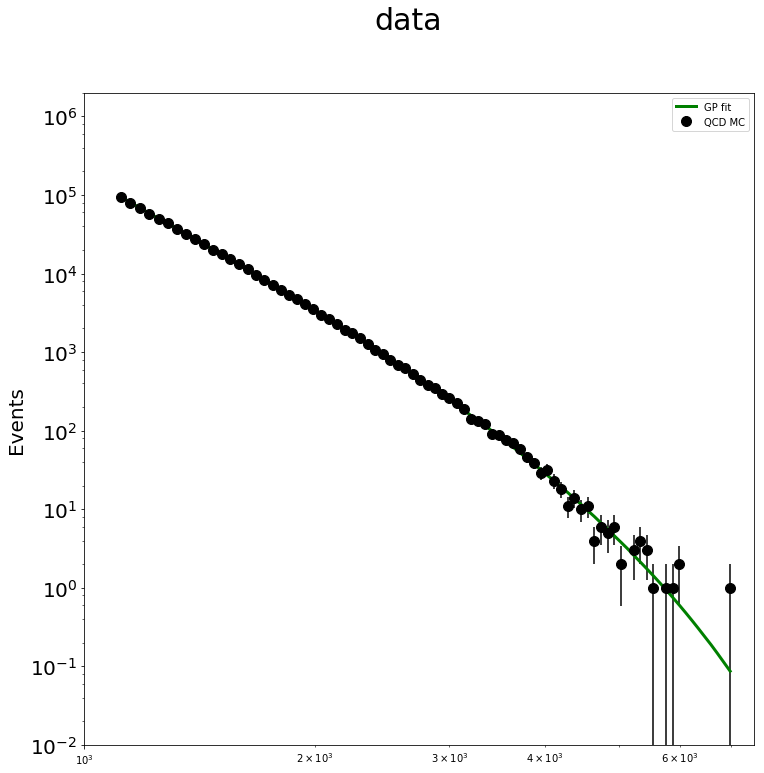

In [58]:
basicPlot(xvalO, yvalO, bkg3param, "data")

In [59]:
#makePrettyPlots(xvalO, yvalO, asimov, "3 param on ATLAS data")

#### run emcee to sample posterior, create covariance matrix

In [60]:
p=best_fit_params
samples = fit_3ff_emcee(p, logLike_3ff_emcee, yvalO)

pvalues = samples.flatchain
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01641503  8.41646543 -5.22785884]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


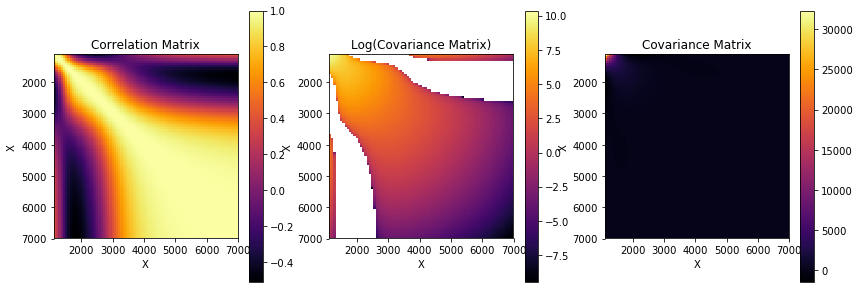

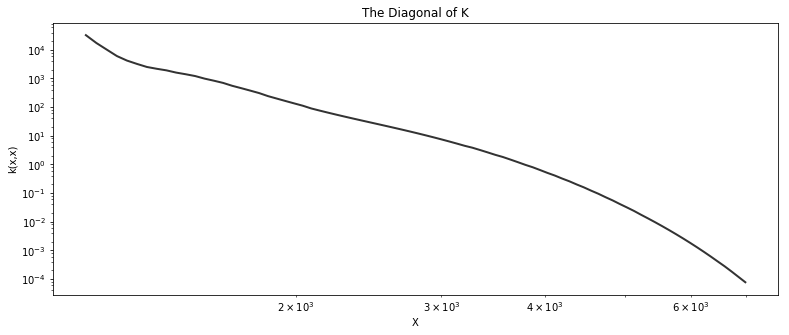

In [61]:
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix3p[:100]).tolist(), "", ymax = 2e5)

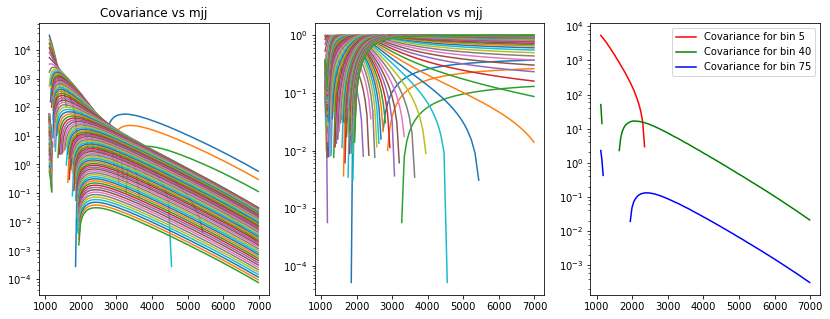

In [62]:
plot_individualCov(corMat, covMat)

### 3 param fit on smooth data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and 3 parameter fit function from fit

In [63]:
lnProb = logLike_3ff_minuit(xvalO, smooth ,xerrO)
bestLLH, best_fit_params = fit_3ff_minuit(100, lnProb)
bkg3param = model_3param(xvalO, best_fit_params, xerrO)

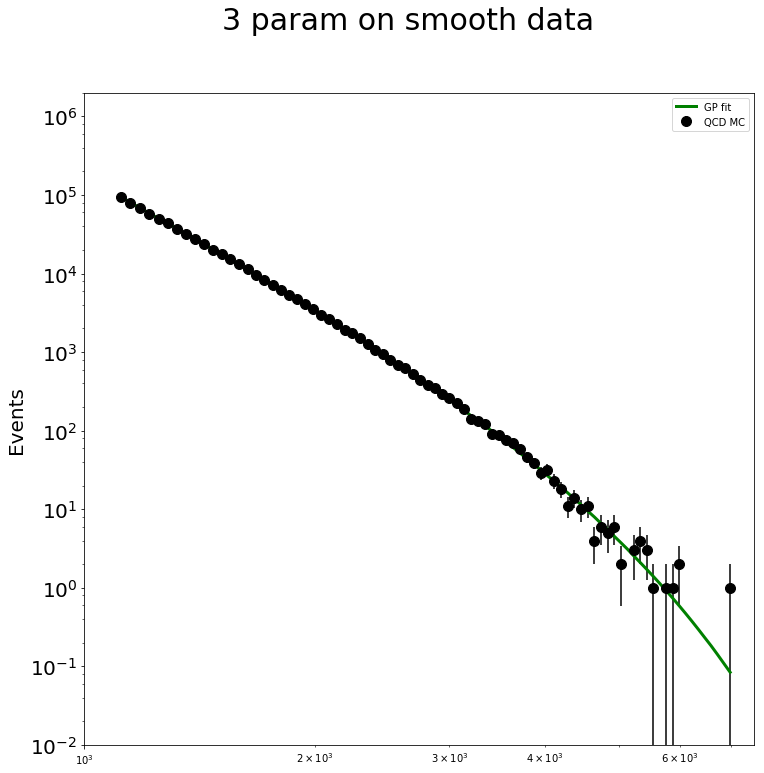

In [64]:
#makePrettyPlots(xvalO, asimov, bkg3param, "3 param on smooth data")
basicPlot(xvalO, yvalO, bkg3param, "3 param on smooth data")

#### run emcee to sample posterior, create covariance matrix WRONG LIKELIHOOD

In [65]:
p=best_fit_params
samples = fit_3ff_emcee(p, logLike_3ff_emcee, smooth)

pvalues = samples.flatchain
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01651159  8.43534953 -5.22610102]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


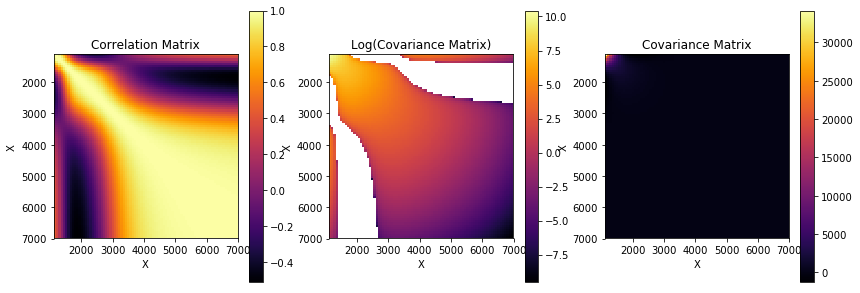

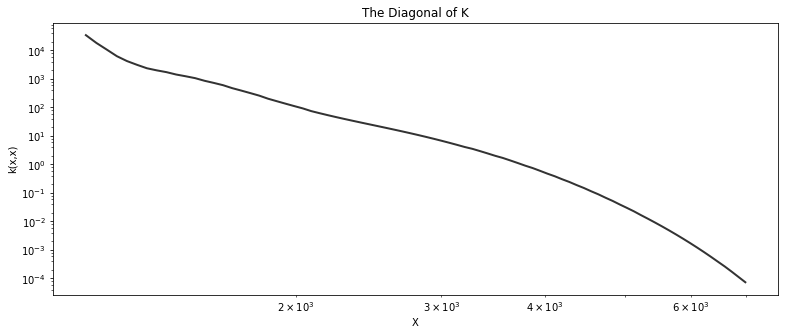

In [66]:
plot_cov(xvalO2D, corMat, covMat, False)

### GP fit on atlas data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and mean and covaraince of predictive distribution 
* use 3 parameter fit function as mean, fit mean parameters and kernel parameters

In [67]:
lnProb = logLike_gp_minuit(xval,yval, xerr)
bestLLH, best_fit_hyperparams = fit_gp_minuit(lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = best_fit_hyperparams
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp(best_fit_hyperparams[5:],xval, xerr), xvalO)
meanGP = meanGPp + model_3param(xvalO,best_fit_hyperparams[5:],xerrO)

min LL 310.6963276
best fit vals (8.827072323607347, 139.6311463252177, 19.139327894097246, -199.91684768677095, 39.257060213017105, 0.01661510723431847, 8.463590655793077, -5.222495212771308)


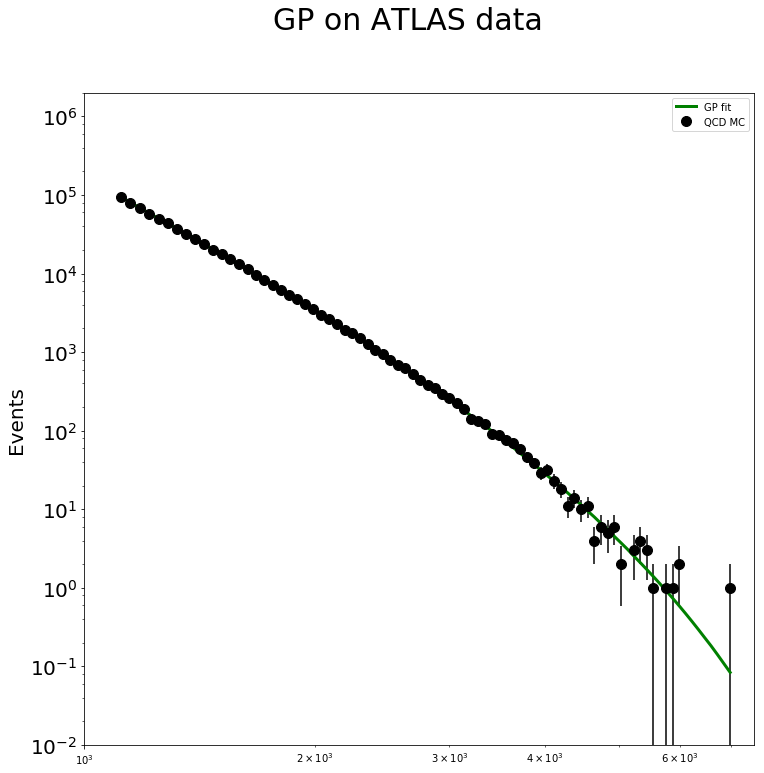

In [68]:
#makePrettyPlots(xvalO, yvalO, meanGP, "GP on ATLAS data")
basicPlot(xvalO, yvalO, meanGP, "GP on ATLAS data")

#### sample posterior, create covariance matrix

In [69]:
samps = gp.sample_conditional(yval - model_gp(best_fit_hyperparams[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,best_fit_hyperparams[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

(1000, 83)
(1000, 83)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


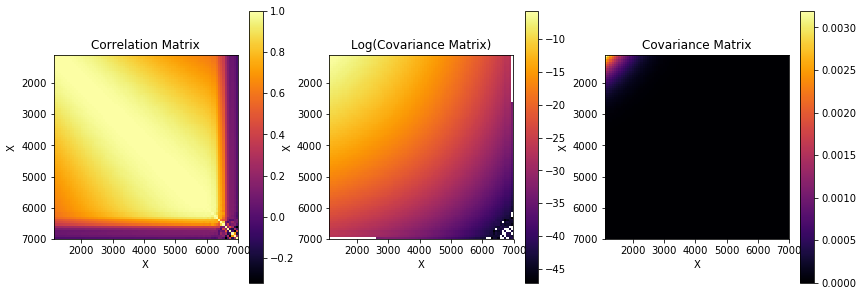

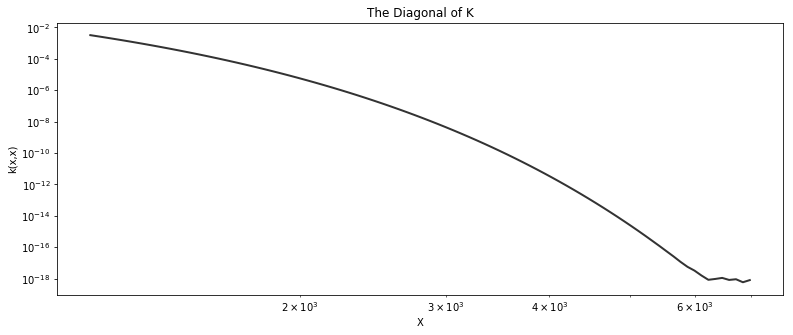

In [70]:
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgp[:100]).tolist(), "", ymax = 2e5)

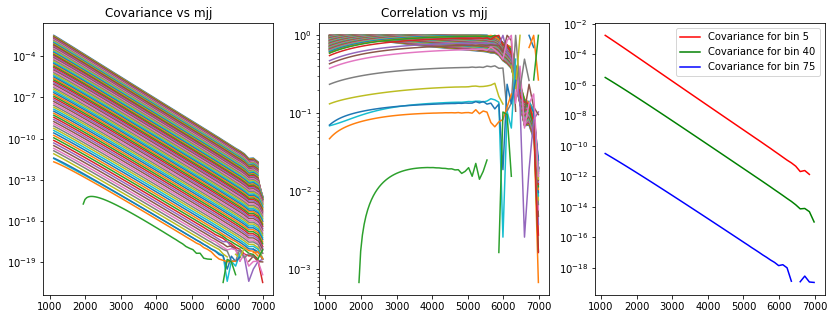

In [71]:
plot_individualCov(corMat, covMat)

### GP fit on smooth data
* return minimum log likelihood, parameter values that correspond to minimum likelihood, and mean and covaraince of predictive distribution 
* use 3 parameter fit function as mean, fit mean parameters and kernel parameters

In [73]:
lnProb = logLike_gp_minuit(xvalO,smooth, xerrO)
bestLLH, best_fit_hyperparams = fit_gp_minuit(lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = best_fit_hyperparams
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xvalO, np.sqrt(smooth))
meanGPp, covGP = gp.predict(smooth - model_gp(best_fit_hyperparams[5:],xvalO, xerrO), xvalO)
meanGP = meanGPp + model_3param(xvalO,best_fit_hyperparams[5:],xerrO)

min LL 287.91682286
best fit vals (27496.949961320293, 60.0172134617864, 87.75829193974879, -130.80000288295952, 97.82007821785625, 0.016553904647264583, 8.454543191852755, -5.223677236737332)


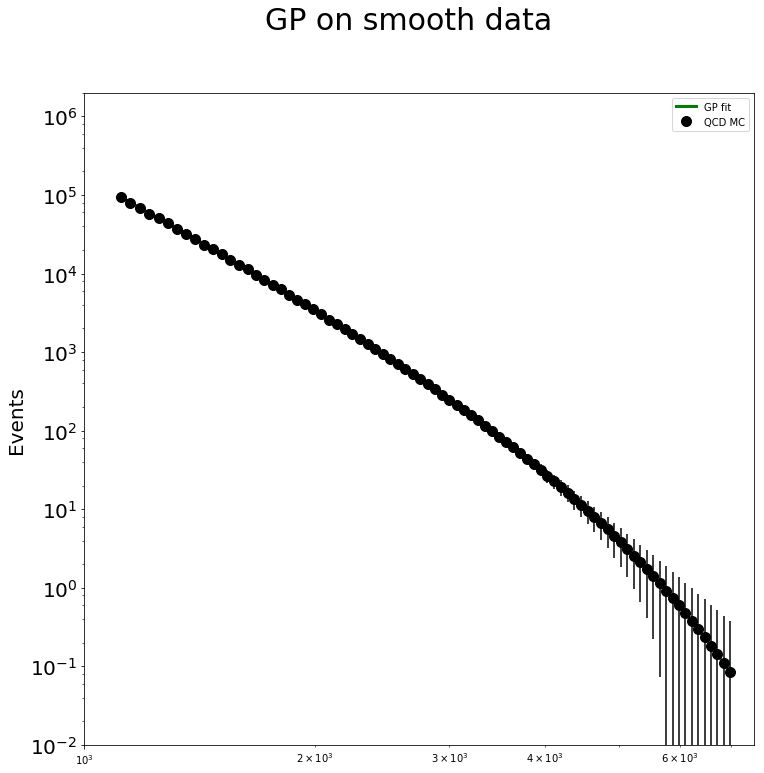

In [74]:
basicPlot(xvalO, smooth, meanGP, "GP on smooth data")
#makePrettyPlots(xvalO, asimov, meanGPnom, "GP on smooth data")

#### sample posterior, create covariance matrix

In [75]:
samps = gp.sample_conditional(smooth - model_gp(best_fit_hyperparams[5:],xvalO, xerrO), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:] + model_3param(xvalO,best_fit_hyperparams[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

(1000, 83)
(1000, 83)


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


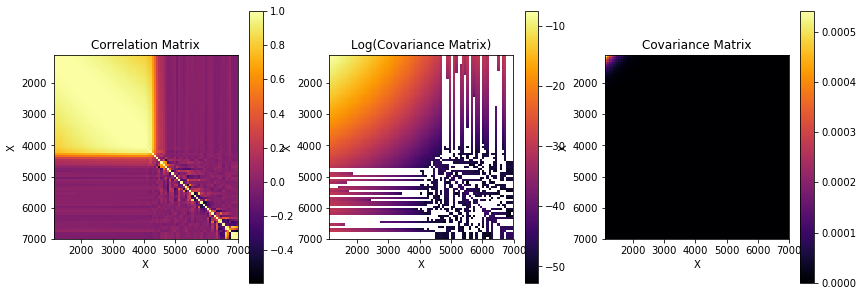

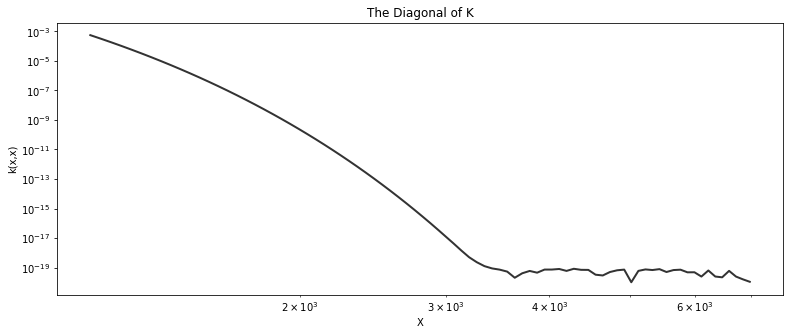

In [76]:
plot_cov(xvalO2D, corMat, covMat, False)